In [1]:
# !pip install docplex
# !pip install numpy
# !pip install matplotlib

In [2]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt 

from docplex.mp.model import Model

from plot_solution import plot_solution

In [3]:
# create one model instance, with a name
M = Model(name='UMApHMP')

In [4]:
# number of nodes
n = 5
Range = range(n)
alpha = 0.75
p = 2
# C should be calculated from the points, but I had values for C from the paper
points = [(0,0), (0,4), (1,5), (3,0), (5,1)]
point_names = ['A', 'B','C', 'D', 'E']

In [5]:
# distance
C = np.matrix([[0, 4, sqrt(26), 3, sqrt(26)], 
               [4, 0, sqrt(2), 5, sqrt(34)],
               [sqrt(26), sqrt(2), 0, sqrt(29), 4*sqrt(2)],
               [3, 5, sqrt(29), 0, sqrt(5)],
               [sqrt(26), sqrt(34), 4*sqrt(2), sqrt(5), 0]])
C

matrix([[0.        , 4.        , 5.09901951, 3.        , 5.09901951],
        [4.        , 0.        , 1.41421356, 5.        , 5.83095189],
        [5.09901951, 1.41421356, 0.        , 5.38516481, 5.65685425],
        [3.        , 5.        , 5.38516481, 0.        , 2.23606798],
        [5.09901951, 5.83095189, 5.65685425, 2.23606798, 0.        ]])

In [6]:
# demand
W = np.ones((n,n))
for i in range(n):
  W[i,i] = 0
W 

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [7]:
X = {(i,j,k,m): M.binary_var(name='X_{0}_{1}_{2}_{3}'.format(i,j,k,m)) for i in Range for j in Range for k in Range for m in Range} # define Xijkm

In [8]:
H = {k: M.binary_var(name='H_{0}'.format(k)) for k in Range} # define Hk (i.e. Xkk)

In [9]:
M.add_constraint(M.sum(H[k] for k in Range) == p) # (4)

docplex.mp.LinearConstraint[](H_0+H_1+H_2+H_3+H_4,EQ,2)

In [10]:
# Xik is 0 or 1 - I am not sure why would we need it when it doesn't appear anymore (5)

In [11]:
# Xijkm >= 0 is default behavior (10)

In [12]:
for i in Range:
  for j in Range:
    M.add_constraint(M.sum(M.sum(X[i,j,k,m] for m in Range) for k in Range) == 1) # (14)

In [13]:
for i in Range:
  for j in Range:
    for k in Range:
      for m in Range:
        M.add_constraint(X[i,j,k,m] <= H[k]) # (15)

In [14]:
for i in Range:
  for j in Range:
    for k in Range:
      for m in Range:
        M.add_constraint(X[i,j,k,m] <= H[m]) # (16)

In [15]:
M.minimize(M.sum(M.sum(M.sum(M.sum(W[i][j]*X[i,j,k,m]*(C[i,k]+C[m,j]+alpha*C[k,m]) for m in Range) for k in Range) for j in Range) for i in Range)) # (7)

In [16]:
M.print_information()

Model: UMApHMP
 - number of variables: 630
   - binary=630, integer=0, continuous=0
 - number of constraints: 1276
   - linear=1276
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [17]:
solution = M.solve()

In [18]:
# Calculate the total flow between every pair of nodes given allocated variables from the solution
def get_flow(Xijkl):
  flow = np.zeros((n,n))

  for i in Range:
    for j in Range:
      for k in Range:
        for l in Range:
          if Xijkl[i,j,k,l] == 1:
            if i != j:
              flow[i,j] += W[i,l]
            if j != k:
              flow[j,k] += W[i,l]
            if k != l:
              flow[k,l] += W[i,l]

  return flow

In [19]:
if solution:
  solution.display()
else:
  print("CPLEX failed to find the solution!")

solution for: UMApHMP
objective: 86.582
status: OPTIMAL_SOLUTION(2)
X_0_0_3_3 = 1
X_0_1_1_1 = 1
X_0_2_1_1 = 1
X_0_3_3_3 = 1
X_0_4_3_3 = 1
X_1_0_1_1 = 1
X_1_1_1_1 = 1
X_1_2_1_1 = 1
X_1_3_1_3 = 1
X_1_4_1_1 = 1
X_2_0_1_1 = 1
X_2_1_1_1 = 1
X_2_2_3_3 = 1
X_2_3_1_3 = 1
X_2_4_1_1 = 1
X_3_0_3_3 = 1
X_3_1_3_1 = 1
X_3_2_3_1 = 1
X_3_3_1_1 = 1
X_3_4_3_3 = 1
X_4_0_3_3 = 1
X_4_1_1_1 = 1
X_4_2_1_1 = 1
X_4_3_3_3 = 1
X_4_4_1_1 = 1
H_1 = 1
H_3 = 1


In [20]:
Xijkl = {}
Xijkl = {(i,j,k,l): solution.get_var_value(X[i,j,k,l]) for i in Range for j in Range for k in Range for l in Range}
# Z_allocated = {(i,k): solution.get_var_value(Z[i,k]) for i in Range for k in Range}


In [21]:
Hubs = [solution.get_var_value(H[i]) for i in Range]

In [22]:
flow = get_flow(Xijkl)

In [23]:
solution.objective_value

86.58178798836512

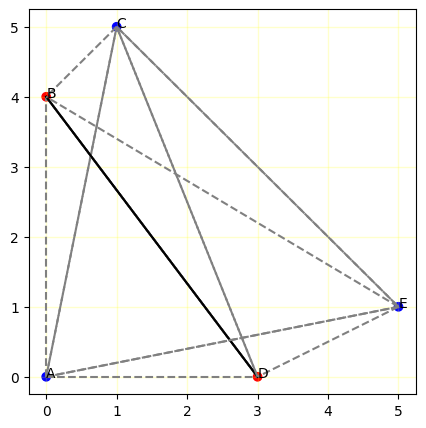

In [24]:
fig, ax = plt.subplots(1, figsize=(5, 5))
plot_solution(ax, points, point_names, Hubs, flow)
plt.show()